In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Dataset

In [2]:
def generate_linear(n=100):
    pts = np.random.uniform(0,1,(n,2))
    inputs = []
    labels = []
    for pt in pts:
        inputs.append([pt[0],pt[1]])
        distance = (pt[0]-pt[1])/1.414
        if pt[0] > pt[1]:
            labels.append(0)
        else:
            labels.append(1)
    return {"x":np.array(inputs), "y":np.array(labels).reshape(n,1)}
def generate_XOR_easy():
    inputs = []
    labels = []
    for i in range(11):
        inputs.append([0.1*i,0.1*i])
        labels.append(0)
        if 0.1*i == 0.5:
            continue
        inputs.append([0.1*i,1-0.1*i])
        labels.append(1)
    return {"x":np.array(inputs),"y":np.array(labels).reshape(21,1)}


In [3]:
def show_data(train,test):

    plt.subplot(1,2,1)
    x,y = train["x"],train["y"]
    plt.title("Ground truth",fontsize=18)
    for i in range(x.shape[0]):
        if y[i]==0:
            plt.plot(x[i][0],x[i][1],'ro')
        else:
            plt.plot(x[i][0],x[i][1],'bo')
    
    plt.subplot(1,2,2)
    x,y = test["x"],test["predict"]
    plt.title('Predict result',fontsize=18)
    for i in range(x.shape[0]):
        if y[i]<0.5:
            plt.plot(x[i][0],x[i][1],'ro')
        else:
            plt.plot(x[i][0],x[i][1],'bo')
    plt.show()
def learning_curve(loss):
    plt.title("Learning Curve")
    plt.plot(loss)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.show()


## Construct Model


In [4]:
def activate(x,act):
    if act == "sigmoid":
        return 1.0/(1.0 + np.exp(-x))
    elif act == "tanh":
        return np.tanh(x)
    elif act == "relu":
        return np.maximum(0.0,x)
    elif act == "leaky_relu":
        return np.maximum(0.01*x,x)
    elif act == "softmax":
        return np.exp(x)/sum(np.exp(x))
    elif act =="none":
        return x

def d_activate(x,act,input):
    if act == "sigmoid":
        return np.multiply(x,1.0-x)
    elif act == "tanh":
        return 1.0 - x ** 2
    elif act == "relu":
        x[x <= 0] = 0
        x[x>0] = 1.0
        return x
    elif act == "leaky_relu":
        x[x > 0.0] = 1.0
        x[x <= 0.0] = 0.01
        return x
    elif act=="softmax":
        
        gradient = np . zeros([x.shape[0],x.shape[1]])
        for i in range(len(x)):
            for j in range(len(input)):
                if i == j:
                    gradient[i][0] = x[i] * (1-input[i])
                else: 
                    gradient[i][0] = -x[i]*input[j]
        return gradient
    elif act =="none":
        x[::] = 1.0
        return x

class Optimizer:

    def __init__(self,in_num,out_num,opt):
        self.v_pre = np.zeros((in_num + 1, out_num))
        self.opt = opt
        self.eps = 1e-8
        

    def run(self,lr,gradient):

        if self.opt == "gd":
            return lr*gradient

        elif self.opt == "momentum":
            self.v_pre = 0.9*self.v_pre - lr * gradient
            return -self.v_pre

        elif self.opt == "adagrad":
            self.v_pre  = self.v_pre + gradient**2
            return (lr / np.sqrt(self.v_pre) + self.eps) * gradient

        elif self.opt == "RMSProp":
            beta = 0.9
            self.v_pre = beta*self.v_pre + (1-beta) * gradient**2
            return (lr / np.sqrt(self.v_pre) + self.eps) * gradient
        elif self.opt == "Adam":
            beta1,beta2 = 0.9,0.9
            m_t = beta1 * self.v_pre + (1-beta1) * gradient
            self.v_pre = beta2 * self.v_pre + (1-beta2) * gradient**2
            return (lr / np.sqrt(self.v_pre) + self.eps) * m_t

    
def count_loss(predict, ground_truth,ls):
    if ls == "mse":
        return np.mean((ground_truth - predict)**2)
    elif ls == "binary_cross_entropy":
        m = ground_truth.shape[1] 
        cost = -1 / m * (np.multiply(ground_truth, np.log(predict)) + np.multiply(1 - ground_truth, np.log(1 - predict)))
        return sum(cost)[0]

def d_loss(predict,ground_truth,ls):
    if ls == "mse":
        return (-2) * (ground_truth - predict) / ground_truth.shape[0]
    elif ls == "binary_cross_entropy":
        return -(np.divide(ground_truth, predict) - np.divide(1 - ground_truth, 1 - predict))


In [5]:
class Layer:
    def __init__(self,in_num,out_num,act,param):
        self.w = np.random.normal(0,1,(in_num+1,out_num))
        self.activate = act
        self.optimizer = Optimizer(in_num,out_num,param["Optimizer"])
    def forward(self,input):
        # 加上 bias 的 neuron
        self.input = np.append(input, np.ones((input.shape[0], 1)), axis=1) 
        self.output = activate(np.matmul(self.input,self.w),self.activate) # o = sig(wx + b)
        return self.output
    
    def backward(self,pre_loss_gradient):
        """
        :param pre_loss_gradient:某node的前一層node的loss經過weight傳到此的值,大小為 [樣本數,這層的neuron數] EX:[100,1]
        :param neuron_gradient:某個node的loss值,大小為 [樣本數,這層的neuron數] EX:[100,1]
        :param lass_neuron_gradientt:是為了算下一層用,透過weight做傳輸,大小為 [樣本數,上層out的neuron數] EX:[100,2]
        """
        self.neuron_gradient = np.multiply(pre_loss_gradient,d_activate(self.output,self.activate,np.matmul(self.input,self.w)))
        lass_neuron_gradient = np.matmul(self.neuron_gradient, self.w[:-1].T) 
        return lass_neuron_gradient
        
    def update(self,lr):

        self.weight_gradient = np.matmul(self.input.T,self.neuron_gradient)
        self.w -= self.optimizer.run(lr,self.weight_gradient)

In [6]:
class NN:
    """
    :param hidden_units: a list ex:[3,2]

    """
    def __init__(self,input_units,hidden_units,output_ubits,param):

         # input layer
        self.layers = [Layer(input_units,hidden_units[0],param["Activate"],param)] 
        # hidden layer
        for i in range(len(hidden_units)-1):
            self.layers.append(Layer(hidden_units[i],hidden_units[i+1],param["Activate"],param))  
        # output layer
        self.layers.append(Layer(hidden_units[-1],output_ubits,"sigmoid",param))   

    def forward(self,input):
        for layer in self.layers:
            input = layer.forward(input)
        return input

    def backward(self,d_loss):
        """
        由最後一層往前算回去
        :param d_loss參數: (樣本數,此層out的neuron數) EX:(100,1)
        :param d_loss 回傳: (樣本數,前一層out的neuron數)
        """
        for layer in self.layers[::-1]:
            d_loss = layer.backward(d_loss)

    def update(self,lr):
        for layer in self.layers:
            layer.update(lr)  

    def train(self,param,data):
        total_loss = []
        for epoch in  range(param['epoch_num']):
            self.predict = self.forward(data["x"])
            loss = count_loss(self.predict,data["y"],param["loss"][0])
            total_loss.append(loss)
            self.backward(d_loss(self.predict,data["y"],param["loss"][0]))
            self.update(param["learning_rate"])
            if epoch%param['epoch_show'] == 0:
                print('epoch {:4d} loss : {:.4f}'.format( epoch, loss))
        
            if loss<param['loss'][1]:
                print('converge! At epoch {:4d} loss : {:.4f}'.format( epoch, loss))
                break
        return total_loss
    def test(self,data):
        predict = self.forward(data['x'])
        print('test loss : ', count_loss(predict, data['y'],param["loss"][0]))
        print('test accuracy : {:3.2f}%'.format(np.count_nonzero(np.round(predict) == data['y']) * 100 / len(data['y'])))
        
        return {"x":data['x'],"predict":self.forward(data['x'])}


linear model 
lr:0.1 
hidden:[3, 2] 
Activate:sigmoid 
Optimizer:gd
Loss:binary_cross_entropy
epoch    0 loss : 95.0146
epoch  500 loss : 5.8252
epoch 1000 loss : 2.1324
epoch 1500 loss : 1.7368
epoch 2000 loss : 1.5187
epoch 2500 loss : 1.3902
epoch 3000 loss : 1.3010
epoch 3500 loss : 1.2344
epoch 4000 loss : 1.1781
epoch 4500 loss : 1.1283
converge! At epoch 4979 loss : 0.4918
test loss :  1.3856090887116659
test accuracy : 100.00%


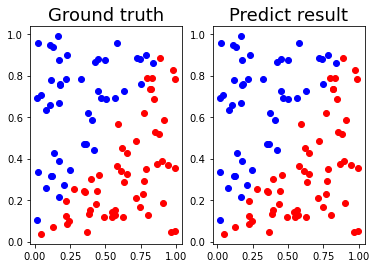

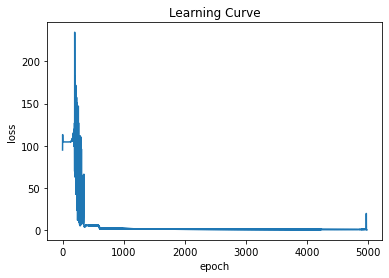


xor model 
lr:0.1 
hidden:[3, 2] 
Activate:sigmoid 
Optimizer:gd
Loss:binary_cross_entropy
epoch    0 loss : 17.5090
epoch  500 loss : 12.2618
converge! At epoch  920 loss : 0.4999
test loss :  0.4974900530782451
test accuracy : 100.00%


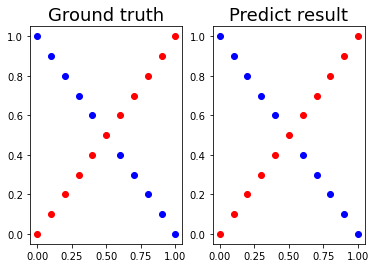

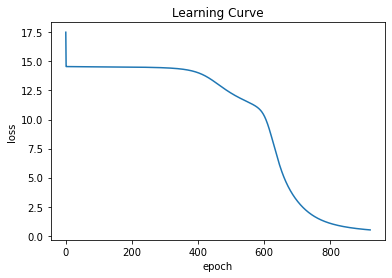

In [7]:
if __name__ == "__main__":
    
    param = {
        "epoch_num" : 100000,
        "epoch_show" : 500,
        "learning_rate":0.1,  
        "hidden_layer":[3,2],
        "Activate":"sigmoid",
        "Optimizer":"gd",
        "loss":("binary_cross_entropy",0.5),

        "learning_rate_list":[1e1000,1,0.1],
        "hidden_layer_list":[[1,1],[3,2],[100,100]],
        "Activate_list":["sigmoid","tanh","relu","leaky_relu"], # relu:xor做的不好
        "Optimizer_list":["gd","momentum","adagrad","RMSProp","Adam"], # adagrad:xor普普
        "loss_list":[("mse",0.005,1),("binary_cross_entropy",1,0.1)],
        "Name":["linear","xor"],
        "linear_data":{"train":generate_linear(),"test":generate_linear()},
        "xor_data":{"train":generate_XOR_easy(),"test":generate_XOR_easy()},

    }
    param_list = []  
    param_list.append(param)
    
    for parameter in param_list:

        for name in param["Name"]:    
            print(f'\n{name} model \nlr:{parameter["learning_rate"]} \nhidden:{parameter["hidden_layer"]} \nActivate:{parameter["Activate"]} \nOptimizer:{parameter["Optimizer"]}\nLoss:{param["loss"][0]}')
           
            data = param[f"{name}_data"]
            model = NN(2,parameter["hidden_layer"],1,parameter)
            
            total_loss = model.train(parameter,data['train'])
            predict = model.test(data['test'])
            
            show_data(data["test"],predict)
            learning_curve(total_loss)

